In [0]:
from sklearn.cluster import KMeans
from scipy.spatial import distance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance
from sklearn import linear_model
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
df = pd.read_csv('./usps.test',header=None)

y_test=df.iloc[:,0]
X_test=df.iloc[:,df.columns!=0]


df = pd.read_csv('./usps.train',header=None)

y_trn=df.iloc[:,0]
X_trn=df.iloc[:,df.columns!=0]


df = pd.read_csv('./usps.valid',header=None)

y_val=df.iloc[:,0]
X_val=df.iloc[:,df.columns!=0]



In [0]:
# 1.a

from sklearn.decomposition import PCA
pca = PCA(n_components=16)

pca_fit = pca.fit(X_trn)
pca_X=pca_fit.transform(X_trn)
x16=pca.inverse_transform(pca_X)
clf=linear_model.SGDClassifier(max_iter=1000,loss='hinge',alpha=0.0001)
clf.fit(x16,y_trn)
print(pca.n_components)


for i in range(0,15):
    plt.imshow(np.reshape(pca.components_[i],(16,16)))
    plt.show()

#principalDf = pd.DataFrame(data = principalComponents)



#filtered = pca.inverse_transform(components)
#plot_digits(filtered)


#for i in range(1,16):
 #   eigenvector = np.array([pca.components_[i]]).T
  #  plt.plot(eigenvector)
    

In [0]:
#1.b

from sklearn.decomposition import PCA
pca = PCA(n_components=50)
principalComponents = pca.fit(X_trn)

#variance = principalComponents.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(principalComponents.explained_variance_ratio_, decimals=3)*100)

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
#plt.ylim(70,100.5)

plt.xticks(np.arange(0,55,2.0))
plt.style.context('seaborn-whitegrid')


plt.plot(var)
plt.grid(True)
plt.plot(var)



In [0]:
#1.c
#k=k70


from sklearn.decomposition import PCA
pca = PCA(n_components=17)

pca_fit = pca.fit(X_trn)
pca_X=pca_fit.transform(X_trn)
x70=pca.inverse_transform(pca_X)
for al in [0.0001, 0.001, 0.01, 0.1]:
    clf=linear_model.SGDClassifier(max_iter=1000,penalty='l2',loss='hinge',alpha=al)
    print('Alpha is ',al)
    clf.fit(x70,y_trn)
    print(pca.n_components)
    print(1-clf.score(X_val,y_val))

In [0]:
#1.c
#k=k80


from sklearn.decomposition import PCA
pca = PCA(n_components=28)

pca_fit = pca.fit(X_trn)
pca_X=pca_fit.transform(X_trn)
x80=pca.inverse_transform(pca_X)
for al in [0.0001, 0.001, 0.01, 0.1]:
    clf=linear_model.SGDClassifier(max_iter=1000,penalty='l2',loss='hinge',alpha=al)
    print('Alpha is ',al)
    clf.fit(x80,y_trn)
    print(pca.n_components)
    print(1-clf.score(X_val,y_val))

In [0]:
#1.c
#k=k90


from sklearn.decomposition import PCA
pca = PCA(n_components=49)

pca_fit = pca.fit(X_trn)
pca_X=pca_fit.transform(X_trn)
x90=pca.inverse_transform(pca_X)
for al in [0.0001, 0.001, 0.01, 0.1]:
    clf=linear_model.SGDClassifier(max_iter=1000,penalty='l2',loss='hinge',alpha=al)
    print('Alpha is ',al)
    clf.fit(x90,y_trn)
    print(pca.n_components)
    print(1-clf.score(X_val,y_val))

Alpha is  0.0001


C:\Users\SK\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


49
0.09999999999999998
Alpha is  0.001


C:\Users\SK\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


49
0.07999999999999996
Alpha is  0.01


C:\Users\SK\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


49
0.06999999999999995
Alpha is  0.1


C:\Users\SK\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


49
0.07666666666666666


In [0]:
#1.c
#k=k100

for al in [0.0001, 0.001, 0.01, 0.1]:
    clf=linear_model.SGDClassifier(max_iter=1000,penalty='l2',loss='hinge',alpha=al)
    print('Alpha is ',al)
    clf.fit(X_trn,y_trn)
    print(pca.n_components)
    print(1-clf.score(X_val,y_val))

In [0]:
clf=linear_model.SGDClassifier(max_iter=1000,penalty='l2',loss='hinge',alpha=0.01)

clf.fit(x90,y_trn)
print(pca.n_components)
print(1-clf.score(X_test,y_test))

C:\Users\SK\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


49
0.08333333333333337


In [0]:
clf=linear_model.SGDClassifier(max_iter=1000,penalty='l2',loss='hinge',alpha=0.01)

clf.fit(X_trn,y_trn)

print(1-clf.score(X_test,y_test))

C:\Users\SK\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


0.07333333333333336


In [0]:
clf=linear_model.SGDClassifier(max_iter=1000,penalty='l2',loss='hinge',alpha=0.01)

clf.fit(x90,y_trn)
print(clf.score(X_test,y_test))

NameError: name 'x90' is not defined

In [0]:
#2

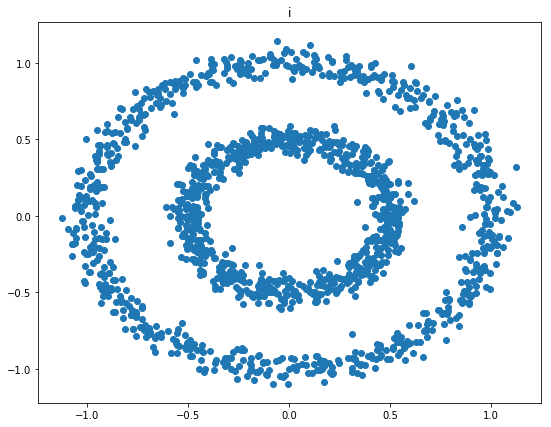

In [0]:
from scipy.spatial import distance

from sklearn import datasets
x = datasets.make_circles(n_samples =1500, factor=.5, noise=.05)



fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('i')
ax.scatter(x[0][:,0],x[0][:,1])







In [0]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

A= rbf_kernel(x[0], gamma = 2000)
print(A.shape)

In [0]:
value=np.sum(A,axis=0)
D=np.eye(1500)
np.fill_diagonal(D, value)
print(D)
L=D-A
print(L)


In [0]:
eigen = np.linalg.eig(L)
eigenvalues=eigen[0]
eigenvec=eigen[1]
print(eigenvalues)

print(eigenvec)

In [0]:
x[1]

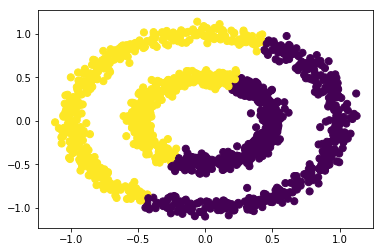

In [0]:
from sklearn.cluster import KMeans
clX=x[0]
clY=x[1]
labels = KMeans(2, random_state=0).fit_predict(clX)
plt.scatter(clX[:, 0], clX[:, 1], c=labels,
            s=50, cmap='viridis');

In [0]:
e1=eigenvec[1]
e2=eigenvec[2]
print(e2)

In [0]:
u=np.array([[1,2,3],[4,5,6],[1,6,8]])
u[1:3].T

In [0]:
eigselected=eigenvec[1:3].T

eigselected[:,0]

In [0]:
#objKMeans = KMeans(eigselected , 'ffp', 2)


#kmeans = KMeans(n_clusters=2, random_state=0).fit(eigselected)
labels = KMeans(2, random_state=0).fit_predict(eigselected)
#kmeans.predict(eigselected)
    

#plt.scatter(clX[:, 0], clX[:, 1], c=labels,
           # s=50, cmap='viridis');

plt.scatter(eigselected[:,0],eigselected[:,1], c=labels,
            );    

In [0]:
k=2
kmeans = KMeans(n_clusters=k, random_state=0).fit(eigselected)
y_kmeans = kmeans.predict(eigselected)

plt.scatter(x[0][:, 0], x[0][:, 1], c=y_kmeans)
#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

In [0]:
def spectral_clustering(x, k):
    A= rbf_kernel(x, gamma = 28)
    D = np.diag(np.sum(A, axis=0))
    l = D - A

    eigenValues, eigenVectors = np.linalg.eigh(l)
    v = eigenVectors[:, 0:k:1]
    kmeans = KMeans(n_clusters=k, random_state=0).fit(v)
    y_kmeans = kmeans.predict(v)

    plt.scatter(x[:, 0], x[:, 1], c=y_kmeans)
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    plt.show()

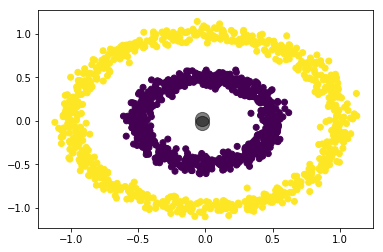

In [0]:
from sklearn import metrics
spectral_clustering(x[0],2)

In [0]:
import os
os.sys.path

In [0]:
import cv2
img = cv2.imread('seg.jpg', 0)
#cv2.imshow('image', img)
img

array([[127, 127, 131, ..., 112, 113, 115],
       [137, 141, 146, ..., 112, 112, 113],
       [124, 132, 138, ..., 111, 111, 110],
       ...,
       [212, 211, 209, ..., 197, 193, 200],
       [187, 184, 181, ..., 199, 194, 182],
       [162, 180, 181, ..., 200, 182, 150]], dtype=uint8)

In [0]:
i=img.flatten()
i=i.reshape(-1,1)

In [0]:
spectral_clustering(i,2)

In [0]:
def spectral_clustering_image(x, k):
    A= rbf_kernel(x, gamma = 27)
    D = np.diag(np.sum(A, axis=0))
    l = D - A

    eigenValues, eigenVectors = np.linalg.eigh(l)
    v = eigenVectors[:, 0:k:1]
    kmeans = KMeans(n_clusters=k, random_state=0).fit(v)
    y_kmeans = kmeans.predict(v)

    plt.figure()
    plt.matshow(y_kmeans, False)
    plt.gca().axis('off')
    plt.title('Clustered')
    

In [0]:
k=2
A= rbf_kernel(i, gamma = 4000)
D = np.diag(np.sum(A, axis=0))
l = D - A

eigenValues, eigenVectors = np.linalg.eigh(l)
v = eigenVectors[:, 0:k:1]
kmeans = KMeans(n_clusters=k, random_state=0).fit(v)
y_kmeans = kmeans.predict(v)

In [0]:
plt.figure()
plt.matshow(y_kmeans, False)
plt.gca().axis('off')
plt.title('Clustered')
    

In [0]:
y_kmeans

In [0]:
plt.imshow(np.reshape(y_kmeans,(9801,121)))
    

In [0]:
plt.imshow(np.reshape(i,(81,121)))
    

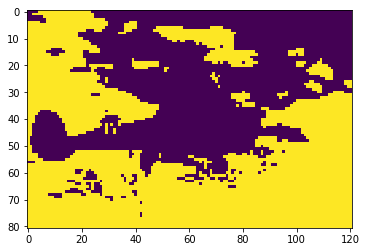

In [0]:
import cv2
img = cv2.imread('./seg.jpg', 0)
img = img/255
samples = np.column_stack([img.flatten()])
original_shape = img.shape
    
clf = KMeans(n_clusters=2)
labels = clf.fit_predict(samples).reshape(original_shape)
plt.imshow(labels)
plt.show()

In [0]:
k=2
A= metrics.pairwise.rbf_kernel(samples, gamma = 65)
D = np.diag(np.sum(A, axis=0))
l = D - A

eigenValues, eigenVectors = np.linalg.eigh(l)
v = eigenVectors[:, 0:k:1]
kmeans = KMeans(n_clusters=k, random_state=0).fit(v)
y_kmeans = kmeans.predict(v)

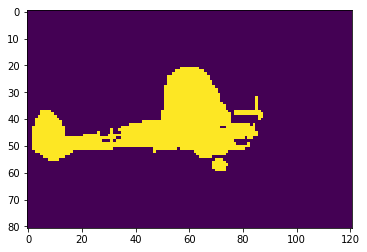

In [0]:
plt.imshow(y_kmeans.reshape(original_shape))
plt.show()

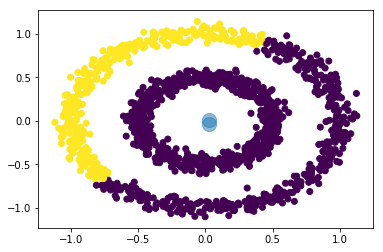

In [0]:
def spectral_clustering(x, k):
    A = metrics.pairwise.rbf_kernel(x, x, gamma=21)
    D = np.diag(np.sum(A, axis=0))
    L = D - A
    
    eigenValues, eigenVectors = np.linalg.eigh(L) 
    new_x = eigenVectors[:,0:k:1]

    kmeans = KMeans(n_clusters=k, random_state=0).fit(new_x) 
    kmeans_predict = kmeans.predict(new_x)
    
    plt.scatter(x[:, 0], x[:, 1], c=kmeans_predict)
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], s=200, alpha=0.5)
    plt.show()

spectral_clustering(x[0], 2)

In [0]:
x[1]

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

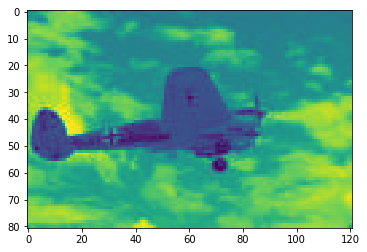

In [0]:
plt.imshow(img)